In [1]:
# Note: this notebook uses the swellSWOT enviroment and python code from https://github.com/ardhuin/swellSWOT 
#       the test data used here is available here:  https://drive.google.com/drive/folders/1Eu_KRgLw6uHMKNFgUUJ6n6w5gY_CMNVB?usp=drive_link 
# 
#   This notebooks demonstrates some basic plotting and manipulation of level 3 spectra from SWOT LR data.  
#
#   Creation: F. Ardhuin. 2024-12-09

import pylab as plt
import numpy as np
from cartopy import crs as ccrs
from netCDF4 import Dataset
import xarray as xr
from scipy import ndimage

import sys as sys
import pickle
import glob as glob
import datetime as dt

import swot_ssh_utils as swot
import swot_swell_utils as swell
from  lib_filters_obp import *


import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.pyplot import cm
import cmocean
import cmocean.cm as cmo

#PATH_with_functions = '/home/ardhuin/TOOLS/OPTOOLS/PYTHON/'
#sys.path.append(PATH_with_functions)
from  spectral_analysis_functions import *
from  wave_physics_functions import *
plt.rcParams.update({'font.size': 18,'savefig.facecolor':'white'})

cNorm = mcolors.Normalize(vmin=0, vmax=2)
jet = plt.get_cmap('jet')
mpl.rcParams.update({'figure.figsize':[10,6],'axes.grid' : True,'font.size': 14,'savefig.facecolor':'white'})

In [2]:
cycle='547';tracks='008';tag='alpha1';figh=5.;latrange=[-20,-9];Lrange=[500,1100];Lstep=100;thrange=[180,270];thstep=30;Hrange=[0,1.5];locleg='upper right';ileg=1;  

lo1=90;la1=-52;t1=np.datetime64('2023-06-06 18', 'ns')   # this is a possible position of Rosemary storm center ... (may be wavelength - dependent) 


folder=''
tracktag='cycle '+cycle+', track '+tracks;
modeltag='REF102040' 

print('looking for files:',folder+'SWOT_L3_LR_Spectra_'+cycle+'_'+tracks+'*'+tag+'.nc' ) 
file_listnc = sorted(glob.glob(folder+'SWOT_L3_LR_Spectra_'+cycle+'_'+tracks+'*'+tag+'.nc'));

ntrack=int(tracks)
sflip=np.mod(ntrack,2)  # orientation of kx,ky is flipped in LOPS version 

L3Snc=xr.open_dataset(file_listnc[0])

looking for files: SWOT_L3_LR_Spectra_547_008*alpha1.nc


box position: 113.63187 -9.5899
model position: 113.5 -9.5
angle: -8.527945
flip: 1 -1 side ind: 1
Values with new mask for latitude  -9.51553 : H18= 0.1710870138348999 L18= 963.4724  H18 model: 0.16900681


/tmp/ipykernel_1863652/1197505462.py:62: RuntimeWarning: divide by zero encountered in log10
  im=ax[1].pcolormesh(kx2*1000,ky2*1000,10*np.log10(E_SWOT_nonoise),cmap='viridis',rasterized=True,vmin=10, vmax=60)


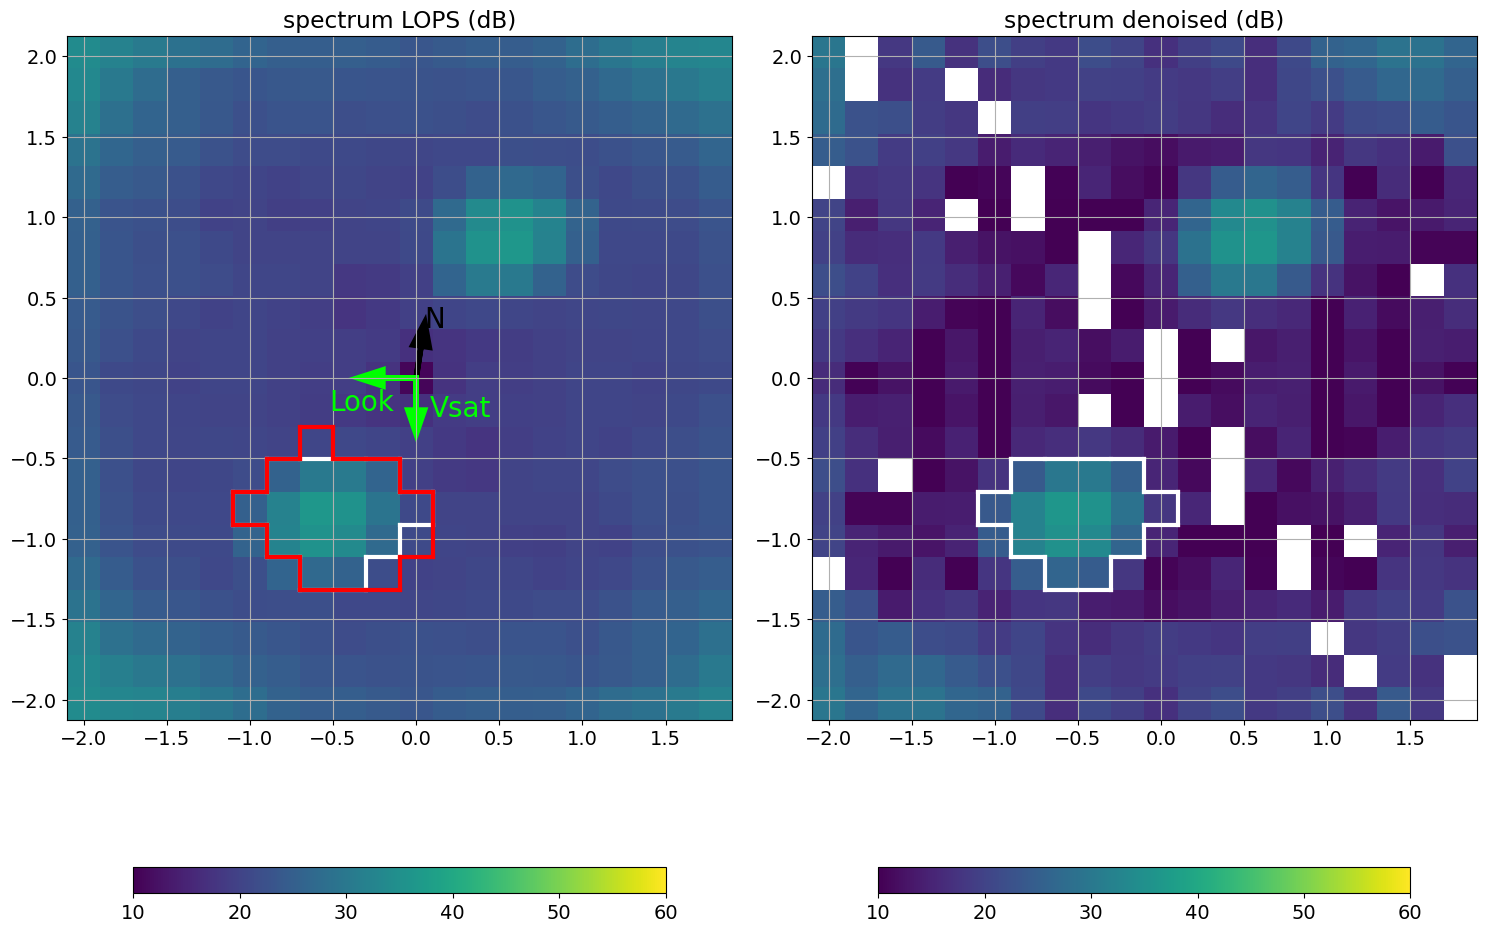

In [4]:
# Plots one single spectrum from LOPS  (and also tests the storm-based mask) 
indside=1
indt=np.where(L3Snc.latitude_40[:,0,indside].values < -35.2)[0][0]
indt=np.where(L3Snc.latitude_40[:,0,indside].values < -9.5)[0][0]

print('box position:',L3Snc.longitude_40[indt,0,indside].values,L3Snc.latitude_40[indt,0,indside].values)
print('model position:',L3Snc.longitude_model[indt,0,indside].values,L3Snc.latitude_model[indt,0,indside].values)

dlat=np.sin(-L3Snc.trackangle[indt].values*np.pi/180)
E_SWOT=L3Snc.E_SWOT_40[indt,0,indside,:,:].values
coh=L3Snc.coh_SWOT_40[indt,0,indside,:,:].values
ang=L3Snc.coh_SWOT_40[indt,0,indside,:,:].values
mask=L3Snc.mask_40[indt,0,indside,:,:].values


sig0mean=L3Snc.sigma0_mean_40[indt,0,0].values
kx2=L3Snc.kx2_40[:,:].values
ky2=L3Snc.ky2_40[:,:].values
#amask2,bmask2=swell.SWOTdefine_swell_mask_simple(E_SWOT,coh,ang,sig0mean,dlat,kx2,ky2,mask_choice=0)

print('angle:',L3Snc.trackangle[indt].values)
la2=L3Snc.latitude_40[indt,0,indside].values; lo2=L3Snc.longitude_40[indt,0,indside].values
now=L3Snc.time[indt].values
tdiff=(now-t1);tds = tdiff / np.timedelta64(1, 's')

amask,bmask=swell.SWOTdefine_swell_mask_storm(kx2,ky2,L3Snc.trackangle[indt].values,lo1,la1,lo2,la2,tds,tola=10E5,thrcos=0.95)


vertices=swell.SWOTspec_mask_polygon(mask) 
vertices2=swell.SWOTspec_mask_polygon(bmask) 

lambdac=L3Snc.lambdac_model[indt,0,indside].values
L3S_ky2=L3Snc.ky2_40.values
L3S_kx2=L3Snc.kx2_40.values
dkx=L3S_kx2[0,1]-L3S_kx2[0,0]
dky=L3S_ky2[1,0]-L3S_ky2[0,0]

#HH1=L3Snc.filter_40.values
HH1=L3Snc.filter_OBP_40.values*L3Snc.filter_PTR_40.values


Hazc=np.exp(-(L3S_ky2*lambdac)**2)
HH3=HH1*Hazc


fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,11.5))
plt.subplots_adjust(left=0.05,bottom=0.07, top=0.92,wspace=0.12,right=0.99)
im=ax[0].pcolormesh(kx2*1000,ky2*1000,10*np.log10(E_SWOT/HH3),cmap='viridis',rasterized=True,vmin=10, vmax=60)
_=plt.colorbar(im,ax=ax[0],label='', location='bottom',shrink=0.8)
_=ax[0].set_title('spectrum LOPS (dB)')
swell.arrows_on_spectrum(ax[0],1-sflip,indside,L3Snc.trackangle[indt],color='k')

dkx=kx2[0,1]-kx2[0,0]
dky=ky2[1,0]-ky2[0,0]
swell.draw_mask(ax[0],kx2,dkx,ky2,dky,vertices,color='w',lw=3)
swell.draw_mask(ax[0],kx2,dkx,ky2,dky,vertices2,color='r',lw=3)

Ekth,kn1,theta1,E_SWOT_nonoise=swell.SWOT_denoise_isotropic(E_SWOT/HH3,kx2,ky2)
Hsnew,Lmm1new,Lmnew,dmnew,Q18=swell.SWOTspec_to_HsLm(E_SWOT,kx2,ky2,mask,(HH3),L3Snc.trackangle[indt])
print('Values with new mask for latitude ',L3Snc.latitude_40[indt,0,0].values,': H18=',Hsnew,'L18=',Lmnew,' H18 model:',L3Snc.H18_model[indt,0,0].values)    

im=ax[1].pcolormesh(kx2*1000,ky2*1000,10*np.log10(E_SWOT_nonoise),cmap='viridis',rasterized=True,vmin=10, vmax=60)
_=plt.colorbar(im,ax=ax[1],label='', location='bottom',shrink=0.8)
_=ax[1].set_title('spectrum denoised (dB)')
swell.draw_mask(ax[1],kx2,dkx,ky2,dky,vertices,color='w',lw=3)



indc: 531 113.615344 -9.938271  angle: 171.48719209319964 -8.512807906800361
size: 531 ## (21, 20)
flip: 0 1 side ind: 1
Values with new mask for latitude  -9.51553 : H18= 0.1796361922238628 L18= 951.785432386104 In file: H18_SWOT= 0.16767039860997188 18_model= 0.2879503688263895


/tmp/ipykernel_1863652/3857777479.py:71: RuntimeWarning: divide by zero encountered in log10
  im=ax[1].pcolormesh(kx2*1000,ky2*1000,10*np.log10(E_SWOT_nonoise),cmap='viridis',rasterized=True,vmin=10, vmax=60)
/tmp/ipykernel_1863652/3857777479.py:71: RuntimeWarning: invalid value encountered in log10
  im=ax[1].pcolormesh(kx2*1000,ky2*1000,10*np.log10(E_SWOT_nonoise),cmap='viridis',rasterized=True,vmin=10, vmax=60)


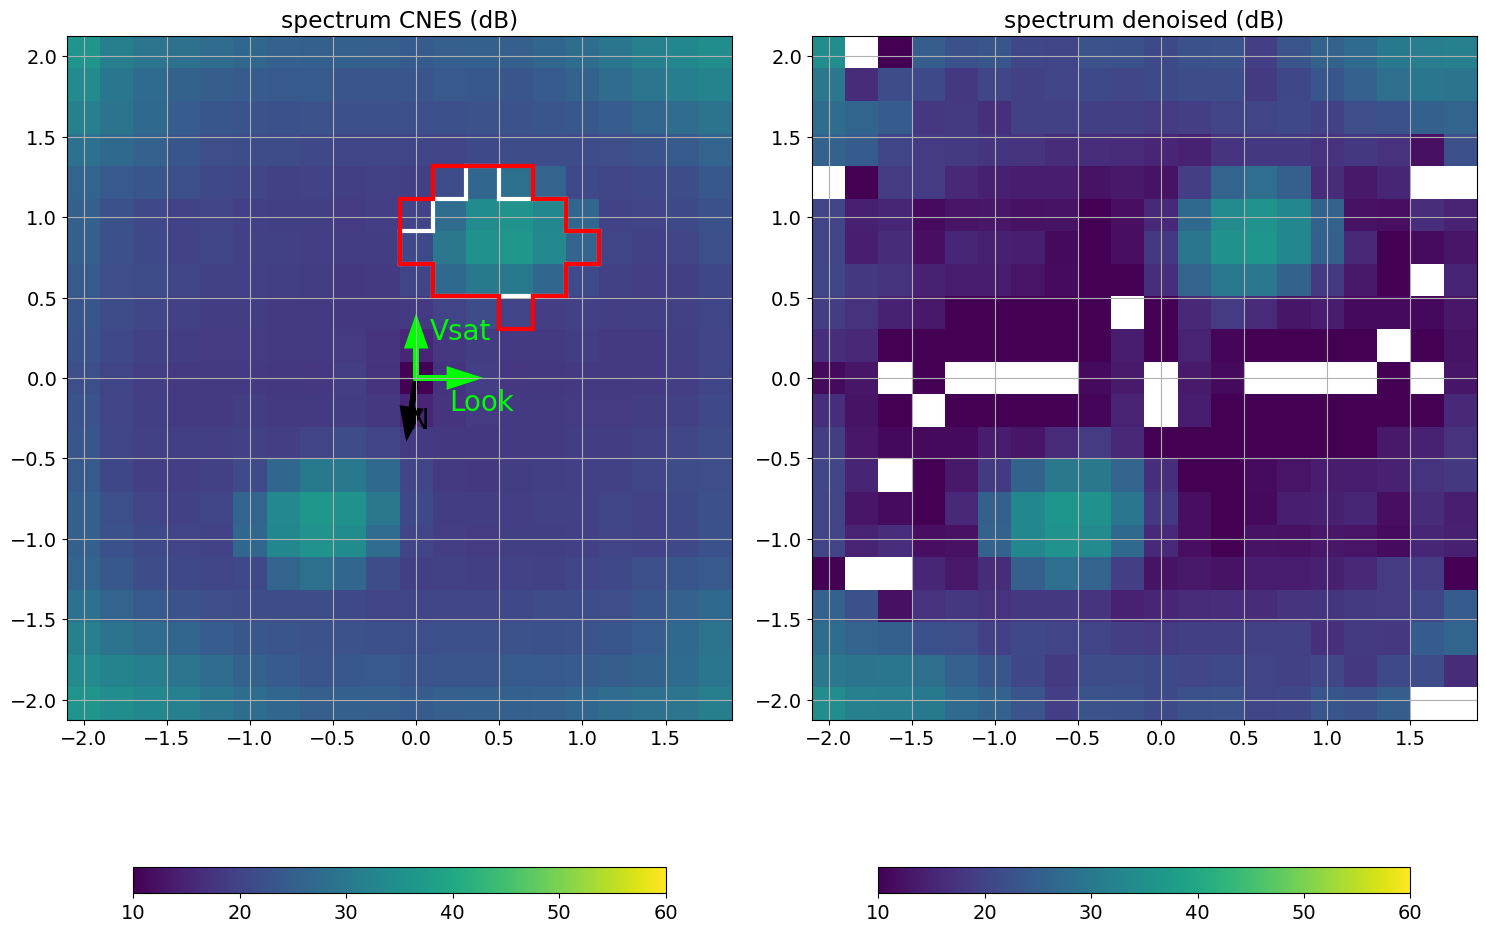

In [5]:
# Plots one single spectrum from CNES


file_listnc = sorted(glob.glob(folder+'L3CNES/SWOT_L3_LR_WIND_WAVE_Basic_'+cycle+'_'+tracks+'*.nc'));
L3SCnc=xr.open_dataset(file_listnc[0])
nspec=len(L3SCnc.latitude.values)


#fig,axs=plt.subplots(1,1,figsize=(16,8))
#axs.scatter(L3SCnc.longitude[0:-1:2],L3SCnc.latitude[0:-1:2],c='black',linewidth=1,label='SWOT left');
#axs.scatter(L3SCnc.longitude[1:-1:2],L3SCnc.latitude[1:-1:2],c='red',linewidth=1,label='SWOT right');

ind1=np.where(L3SCnc.latitude[0:-1:2].values < -9.5)[0]
#ind1=np.where(L3SCnc.latitude[0:-1:2].values < -35)[0]
indc=ind1[0]*2+indside #+1 for rigth swath
print('indc:',indc,L3SCnc.longitude[indc].values,L3SCnc.latitude[indc].values,' angle:',L3SCnc.track_angle[indc].values,L3SCnc.track_angle[indc].values-180)
indm=L3SCnc.index_model[indc].values.astype(int)



#filetr='/media/ardhuin/FabLinux/WW3-SWOT/GLOBAL_'+modeltag+'/SWOT_WW3-GLOB-30M_202306_trck.nc'
#ds_ww3t = xr.open_dataset(filetr)
#print('index of model spectrum used for mask:',indm,ds_ww3t.longitude[indm].values,ds_ww3t.latitude[indm].values,ds_ww3t.time[indm].values)
#modspec,inds,modelfound,timeww3,lonww3,latww3,dist,U10,Udir,dpt=swell.SWOTfind_model_spectrum(ds_ww3t,L3SCnc.longitude[indc].values,L3SCnc.latitude[indc].values,L3SCnc.time[indc].values)
#print('index of model spectrum that should be used:',inds,timeww3,lonww3,latww3)

E_SWOTC=L3SCnc.Ekxky_SWOT[indc,:,:].values
maskC=L3SCnc.swell_mask[indc,:,:].values
print('size:',indc,'##',np.shape(maskC))
kx2=L3SCnc.kx2[:,:].values
ky2=L3SCnc.ky2[:,:].values



dtor=np.pi/180
la2=L3SCnc.latitude[indc].values;lo2=L3SCnc.longitude[indc].values
angt=L3SCnc.track_angle[indc].values


now=L3SCnc.time[indc].values
tdiff=(now-t1);tds = tdiff / np.timedelta64(1, 's')

amask,bmask=swell.SWOTdefine_swell_mask_storm(kx2,ky2,angt,lo1,la1,lo2,la2,tds,tola=10E5,thrcos=0.95)

vertices=swell.SWOTspec_mask_polygon(maskC) 
vertices2=swell.SWOTspec_mask_polygon(bmask) 

lambdac=L3Snc.lambdac_model[indt,0,indside].values
Hazc=np.exp(-(L3S_ky2*lambdac)**2)
HH3=HH1*Hazc


fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,11.5))
plt.subplots_adjust(left=0.05,bottom=0.07, top=0.92,wspace=0.12,right=0.99)
im=ax[0].pcolormesh(kx2*1000,ky2*1000,10*np.log10(E_SWOTC/HH3),cmap='viridis',rasterized=True,vmin=10, vmax=60)
_=plt.colorbar(im,ax=ax[0],label='', location='bottom',shrink=0.8)
_=ax[0].set_title('spectrum CNES (dB)')

dkx=kx2[0,1]-kx2[0,0]
dky=ky2[1,0]-ky2[0,0]
swell.draw_mask(ax[0],kx2,dkx,ky2,dky,vertices,color='w',lw=3)
swell.draw_mask(ax[0],kx2,dkx,ky2,dky,vertices2,color='r',lw=3)
swell.arrows_on_spectrum(ax[0],0,indside,angt,color='k')


Ekth,kn1,theta1,E_SWOT_nonoise=swell.SWOT_denoise_isotropic(E_SWOTC/HH3,kx2,ky2)
Hsnew,Lmm1new,Lmnew,dmnew,Q18=swell.SWOTspec_to_HsLm(E_SWOTC,kx2,ky2,maskC,(HH3),L3Snc.trackangle[indt])
Hsnew,Lmm1new,Lmnew,dmnew,Q18=swell.SWOTspec_to_HsLm(E_SWOTC,kx2,ky2,bmask,(HH3),L3Snc.trackangle[indt])
print('Values with new mask for latitude ',L3Snc.latitude_40[indt,0,0].values,': H18=',Hsnew,'L18=',Lmnew,'In file: H18_SWOT=',L3SCnc.H18[indc].values,'18_model=',L3SCnc.H18_model[indc].values)    

im=ax[1].pcolormesh(kx2*1000,ky2*1000,10*np.log10(E_SWOT_nonoise),cmap='viridis',rasterized=True,vmin=10, vmax=60)
_=plt.colorbar(im,ax=ax[1],label='', location='bottom',shrink=0.8)
_=ax[1].set_title('spectrum denoised (dB)')



In [6]:
# BELOW THIS CELL: things to be cleaned up ... 

In [7]:
modelfound=1
L3S_H18_40=np.squeeze(L3Snc.H18_40.values)
L3S_Hs=np.squeeze(L3Snc.Hs_model.values)
L3S_Tm02=np.squeeze(L3Snc.Tm02_model.values)
timec=L3Snc.time[0].values

L3S_trackangle=np.squeeze(L3Snc.trackangle.values)
[L3Snt,L3Snx]=np.shape(L3S_H18_40)
bigarray_L3S=np.zeros((L3Snt*2,50))
indf=0
L3S_ky2=L3Snc.ky2_40.values
L3S_kx2=L3Snc.kx2_40.values
dkx=L3S_kx2[0,1]-L3S_kx2[0,0]
dky=L3S_ky2[1,0]-L3S_ky2[0,0]

#HH1=L3Snc.filter_40.values
HH1=L3Snc.filter_OBP_40.values*L3Snc.filter_PTR_40.values

# model variables 
modf=L3Snc.frequency.values
moddf=L3Snc.df.values
modang=L3Snc.direction.values
modnth=np.shape(modang)[0]
moddth=(2*np.pi/modnth)


# necessary variables if the SWOT-like spectrum is recomputed ... 
kxmax=-2*L3S_kx2[0,0]
kymax=-2*L3S_ky2[0,0]
[nkyr,nkxr]=np.shape(L3S_kx2)
dkxr=kxmax/nkxr
dkyr=kymax/(nkyr-1)  # only true in nkyr is odd ?? 
kxr=np.linspace(-nkxr*dkxr,(nkxr-1)*dkxr,nkxr*2)
kyr=np.linspace(-nkyr*dkyr,(nkyr-1)*dkyr,nkyr*2)
fx_wreg=kxr*1000
fy_wreg=kyr*1000
kxr2, kyr2 = np.meshgrid(kxr,kyr,indexing='ij') 
kn=np.sqrt(L3S_kx2**2+L3S_ky2**2)*1000
# Defines the spectral response H assocaited to SWOT on board processing and PTR 
x_xt, w_xt, f_xt, H_xt = get_obp_filter(L_filt = 0.980, f_axis = fx_wreg, plot_flag = False, kernel="parzen")
x_at, w_at, f_at, H_at = get_obp_filter(L_filt = 1, f_axis = fy_wreg, plot_flag = False, kernel="bharris")
x_at, w_at, f_obp, H_ptr = get_obp_filter(L_filt = 3, sampling_in = 0.0125,f_axis = fy_wreg, plot_flag = False, kernel="alejandro_azptr")
H = np.repeat(np.array([H_xt]), len(H_at), axis=0).T * np.repeat(np.array([H_at]), len(H_xt), axis=0)
Hptr = np.repeat(np.array([H_ptr]), len(H_xt), axis=0)
H2=H*Hptr                     # note that when model data is also used, H3 is defined below to include az cut-off 

recompute_model_spec=0

adjust_azc=1;calibration=1;denoise=1;

for indside in range(2): 
  for indt in range(L3Snt): 
    bigarray_L3S[indf,0]=L3Snc.time[indt].values
    bigarray_L3S[indf,1]=L3Snc.longitude_40[indt,0,indside].values
    bigarray_L3S[indf,2]=L3Snc.latitude_40[indt,0,indside].values
    bigarray_L3S[indf,3]=L3Snc.time_model[indt,0,indside].values

    bigarray_L3S[indf,10]=L3Snc.H18_40[indt,0,indside].values 
    bigarray_L3S[indf,20]=L3Snc.L18_40[indt,0,indside].values 
    bigarray_L3S[indf,30]=L3Snc.d18_40[indt,0,indside].values
    bigarray_L3S[indf,40]=L3Snc.Q18_40[indt,0,indside].values
    bigarray_L3S[indf,11]=L3Snc.H18_model[indt,0,indside].values 
    bigarray_L3S[indf,21]=L3Snc.L18_model[indt,0,indside].values 
    bigarray_L3S[indf,31]=L3Snc.d18_model[indt,0,indside].values
    bigarray_L3S[indf,41]=L3Snc.Q18_model[indt,0,indside].values
    lambdac=L3Snc.lambdac_model[indt,0,indside].values
    bigarray_L3S[indf,4]=lambdac
    Hazc=np.exp(-(L3S_ky2*lambdac)**2)
    HH3=HH1*Hazc
    
    L3S_E_SWOT=L3Snc.E_SWOT_40[indt,0,indside,:,:].values
    L3S_amask =L3Snc.mask_40[indt,0,indside,:,:].values
    modelfound = 1 #-L3Snc.quality_flag_frac_40[indt,0,indside].values
      
    if (recompute_model_spec==1):
      if (np.mod(indt,50)==0):
               dBE=0;dBE2=10;
               vertices=swell.SWOTspec_mask_polygon(L3S_amask) 
               fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(6,3.5))
               spec = mpl.gridspec.GridSpec(ncols=2, nrows=1,width_ratios=[6, 5])
               plt.subplots_adjust(left=0.05,bottom=0.1, top=0.92,wspace=0.1,right=0.99)
    
# Plotting SWOT spectrum 
               im=ax[0].pcolormesh(L3S_kx2*1000,L3S_ky2*1000,10*np.log10(L3S_E_SWOT),cmap='viridis',rasterized=True,vmin = -10+dBE, vmax=30+dBE)
               _=ax[0].set_title('SWOT spectrum  (dB)')
               swell.draw_mask(ax[0],L3S_kx2,dkx,L3S_ky2,dky,vertices,color='w',lw=3) 
                
    

      efth=L3Snc.efth[indt,0,indside,:,:].values
      [Ef,th1m,sth1m,Hs,Tm0m1,Tm02,Qf,Qkk] = wavespec_Efth_to_first3(efth,modf,moddf, modang,moddth,cut=100.) 
    
      sigu3=(Hs/4)*(2*np.pi/Tm02)
      lambdac=1/((7310/875.0e3)/sigu3/(2*np.pi))

      if modelfound > 0 :
         sigu=(L3S_Hs[indt,indside]/4)*(2*np.pi/L3S_Tm02[indt,indside])
         lambdac=1./((7310/875.0e3)/sigu/(2*np.pi))
      else :
         lambdac=3

      Hazc = np.exp(-(kyr2*lambdac)**2)        # this is the effect of velocity bunching for sigma0 ... what about the phase? 
               
      if adjust_azc==1:
          # recomputes sigu (standard dev. of orbital velocity) for a filtered spectrum (cutting at 100 m wavelength) 
          #[Ef,th1m,sth1m,Hs,Tm0m1,Tm02,Qf,Qkk] = wavespec_Efth_to_first3(efth,modf,moddf, modang.values,moddth,cut=100.) 
          [Ef,th1m,sth1m,Hs,Tm0m1,Tm02,Qf,Qkk] = wavespec_Efth_to_first3(efth,modf,moddf, modang,moddth,cut=100.) 
          sigu3=(Hs/4)*(2*np.pi/Tm02)   # rms orbital velocity 
          lambdac=1./((7310/875.0e3)/sigu3/(2*np.pi))
          Hazc =np.exp(-(L3S_ky2*lambdac)**2)

      H3=H*Hptr*Hazc
  
      Eta_WW3_obp_H2,Eta_WW3_obp_H,Eta_WW3_noa_H2,Eta_WW3_res,Eta_WW3_c,Ekxky,kxm,kym,ix1,iy1= \
                              swell.wavespec_Efth_to_kxky_SWOT(efth,modf,moddf, modang,moddth,f_xt,f_at,H,Hazc,H3, \
                                            kxmax,kymax,dkx,dky,dkxr,dkyr,nkxr,nkyr,doublesided=0,verbose=0,trackangle=(L3S_trackangle[indt]+sflip*180)*np.pi/180)
        

      if (np.mod(indt,50)==0):
               dBE=0;dBE2=10;
               vertices=swell.SWOTspec_mask_polygon(L3S_amask) 
               fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(6,3.5))
               spec = mpl.gridspec.GridSpec(ncols=2, nrows=1,width_ratios=[6, 5])
               plt.subplots_adjust(left=0.05,bottom=0.1, top=0.92,wspace=0.1,right=0.99)
    
# Plotting WW3 spectrum, same resolution as SWOT spectrum 
               im=ax[0].pcolormesh(L3S_kx2*1000,L3S_ky2*1000,10*np.log10(Eta_WW3_obp_H2),cmap='viridis',rasterized=True,vmin = -10+dBE, vmax=30+dBE)
               _=ax[0].set_title('model spectrum  (dB)')
               swell.draw_mask(ax[0],L3S_kx2,dkx,L3S_ky2,dky,vertices,color='w',lw=3) 
                
# Plotting WW3 spectrum, same resolution as SWOT spectrum but 2 x spectral range and no ambiguity in direction 
               im=ax[1].pcolormesh(-kxm[ix1:ix1+nkxr*6]*1000,-kym[iy1:iy1+nkxr*6]*1000,10*np.log10(Ekxky[ix1:ix1+nkxr*6,iy1:iy1+nkxr*6]).T,cmap='viridis',rasterized=True,vmin=-10+dBE2, vmax=30+dBE2)
               _=ax[1].set_title('model unfiltered')
               plt.setp(ax[1].get_yticklabels(), visible=False)
               plt.show()

      
        
      HHC=(HH1)**calibration  # calibration of the PTR
      print(np.shape(HH1),'##',np.shape(HHC),'##',np.shape(Hazc))
      HH3=HHC*Hazc  # filter corrected with calibration for Hptr and new cut-off for Hazc. 
        
    # NB: to be fully correct we should also redo the aliasing calculation with the updated filter ...
      bigarray_L3S[indf,4]=lambdac
    
      Hsnew,Lmm1new,Lmnew,dmnew,Q18=swell.SWOTspec_to_HsLm(L3S_E_SWOT,L3S_kx2,L3S_ky2,L3S_amask,HH3,L3S_trackangle[indt])
      bigarray_L3S[indf,10]=Hsnew
      bigarray_L3S[indf,20]=Lmm1new
      bigarray_L3S[indf,30]=dmnew
      bigarray_L3S[indf,40]=Q18
      b2mask=L3S_amask
      Hsnew,Lmm1new,Lmnew,dmnew,Q18=swell.SWOTspec_to_HsLm(Eta_WW3_obp_H2,L3S_kx2,L3S_ky2,b2mask,HH3,L3S_trackangle[indt])
      bigarray_L3S[indf,11]=Hsnew 
      bigarray_L3S[indf,21]=Lmm1new 
      bigarray_L3S[indf,31]=dmnew 
      bigarray_L3S[indf,41]=Q18 
      
    if (denoise==1):
       Ekth,kn1,theta1,Eta_SWOT_nonoise=swell.SWOT_denoise_isotropic(L3S_E_SWOT/HH3,L3S_kx2,L3S_ky2)
       Hsnew,Lmm1new,Lmnew,dmnew,Q18=swell.SWOTspec_to_HsLm(Eta_SWOT_nonoise,L3S_kx2,L3S_ky2,L3S_amask,(HH3*0+1),L3S_trackangle[indt])
       bigarray_L3S[indf,12]=Hsnew
       bigarray_L3S[indf,22]=Lmm1new
       bigarray_L3S[indf,32]=dmnew
       bigarray_L3S[indf,42]=Q18
       
    indf=indf+1
#L3Snc.close()  # close the L3 spectra file

/tmp/ipykernel_1863652/2697167030.py:68: RuntimeWarning: overflow encountered in square
  Hazc=np.exp(-(L3S_ky2*lambdac)**2)
/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/swot_swell_utils.py:148: RuntimeWarning: invalid value encountered in scalar divide
  Q18=np.sqrt(mQ/(m0**2*dkx*dky))/(2*np.pi)
/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/swot_swell_utils.py:152: RuntimeWarning: invalid value encountered in scalar divide
  Lmp1_SWOT=m0/mp1
/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/swot_swell_utils.py:153: RuntimeWarning: invalid value encountered in scalar divide
  Lmm1_SWOT=mm1/m0


size of arrays: 236


/tmp/ipykernel_1863652/35907007.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0].scatter(bigarray_L3S[s1:-1,10],bigarray_L3S[s1:-1,2],c=gr,alpha=0.5,linewidth=1,label='SWOT');
/tmp/ipykernel_1863652/35907007.py:37: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[1].scatter(bigarray_L3S[s1:-1,20],bigarray_L3S[s1:-1,2],c=gr,alpha=0.5,linewidth=1,label='SWOT right');
/tmp/ipykernel_1863652/35907007.py:60: UserWarni

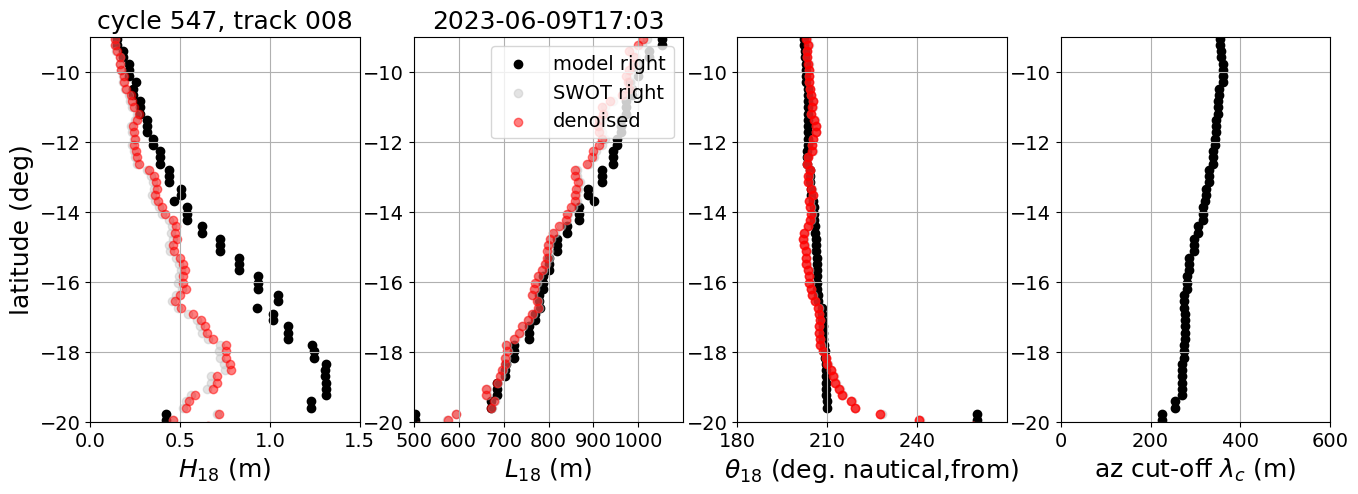

In [8]:
gr=[0.,205./255.,0.]
fig,axs=plt.subplots(1,4,figsize=(16,figh))
vecHs=np.linspace(1,12,23)
s1=indt;s2=-1 # for right swath only 
#s1=0;s2=indt # for right swath only 
print('size of arrays:',indt) 


if s1 < indt  :
   axs[0].scatter(bigarray_L3S[s1:s2,11],bigarray_L3S[s1:s2,2],c='black',linewidth=1,label='model left');
   axs[0].scatter(bigarray_L3S[s2:-1,11],bigarray_L3S[s2:-1,2],c='blue',linewidth=1,label='model  right');
   axs[0].scatter(bigarray_L3S[s2:-1,10],bigarray_L3S[s2:-1,2],c=gr,linewidth=1,label='SWOT  right');
   axs[0].scatter(bigarray_L3S[s1:s2,10],bigarray_L3S[s1:s2,2],c='red',linewidth=1,label='SWOT left');
else: 
   gr=[200./255.,200./255.,200./255.]
   gS=[80./255.,255./255.,80./255.]
   axs[0].scatter(bigarray_L3S[s1:-1,11],bigarray_L3S[s1:-1,2],c='black',linewidth=1,label='model');
   axs[0].scatter(bigarray_L3S[s1:-1,10],bigarray_L3S[s1:-1,2],c=gr,alpha=0.5,linewidth=1,label='SWOT');
   if (denoise==1):
      axs[0].scatter(bigarray_L3S[s1:-1,12],bigarray_L3S[s1:-1,2],c='red',alpha=0.5,linewidth=1,label='denoised');
   
    
axs[0].set_xlabel(r'$H_{18}$ (m)', fontsize=18)
axs[0].set_ylabel('latitude (deg)', fontsize=18)
axs[0].set_title(tracktag, fontsize=18)
axs[0].set_xlim(Hrange);
#axs[0].set_xlim([0,5]);
axs[0].set_ylim(latrange)

if s1 < indt  :
   axs[1].scatter(bigarray[0:nfiles,21],bigarray[0:nfiles,2],c='black',linewidth=1,label='model left');
   axs[1].scatter(bigarray[nfiles+1:-1,21],bigarray[nfiles+1:-1,2],c='blue',linewidth=1,label='model  right');
   axs[1].scatter(bigarray[nfiles+1:-1,20],bigarray[nfiles+1:-1,2],c=gr,linewidth=1,label='SWOT  right');
   axs[1].scatter(bigarray[0:nfiles,20],bigarray[0:nfiles,2],c='red',linewidth=1,label='SWOT left');
else: 
   axs[1].scatter(bigarray_L3S[s1:-1,21],bigarray_L3S[s1:-1,2],c='black',linewidth=1,label='model right');
   axs[1].scatter(bigarray_L3S[s1:-1,20],bigarray_L3S[s1:-1,2],c=gr,alpha=0.5,linewidth=1,label='SWOT right'); 
   if (denoise==1):
      axs[1].scatter(bigarray_L3S[s1:-1,22],bigarray_L3S[s1:-1,2],c='red',alpha=0.5,linewidth=1,label='denoised');

axs[1].set_xlabel(r'$L_{18}$ (m)', fontsize=18)
format = '%Y-%m-%dT%H:%M:%S'
axs[1].set_title(str(timec)[0:16], fontsize=18)
axs[1].set_xlim(Lrange)
axs[1].set_xticks(np.arange(Lrange[0],Lrange[1],Lstep))
#axs[1].set_xlim([450,650])
#axs[1].set_xticks(np.arange(450,650,50))
axs[1].set_ylim(latrange)
leg = axs[ileg].legend(loc=locleg, fontsize=14)

lightcmap = cmocean.tools.lighten(cmo.ice_r, 0.5)

if s1 < indt  :
   axs[2].scatter(bigarray_L3S[s1:s2,31],bigarray_L3S[s1:s2,2],c='black',linewidth=1,label='model left');
   axs[2].scatter(bigarray_L3S[s2:-1,31],bigarray_L3S[s2:-1,2],c='blue',linewidth=1,label='model right');
   axs[2].scatter(bigarray_L3S[s2:-1,30],bigarray_L3S[s2:-1,2],c=gr,linewidth=1,label='SWOT right');
   axs[2].scatter(bigarray_L3S[s1:s2,30],bigarray_L3S[s1:s2,2],c='red',linewidth=1,label='SWOT left');
else: 
   axs[2].scatter(bigarray_L3S[s1:-1,31],bigarray_L3S[s1:-1,2],c='black',linewidth=1,label='model');
   axs[2].scatter(bigarray_L3S[s1:-1,30],bigarray_L3S[s1:-1,2],c=gr,alpha=0.5,linewidth=1,label='SWOT');
   if (denoise==1):
     axs[2].scatter(bigarray_L3S[s1:-1,32],bigarray_L3S[s1:-1,2],c='red',alpha=0.5,linewidth=1,label='denoised');
     axs[2].scatter(bigarray_L3S[s1:-1,32],bigarray_L3S[s1:-1,2],c='red',alpha=0.5,linewidth=1,label='denoised');

axs[2].set_xlabel(r'$\theta_{18}$ (deg. nautical,from)', fontsize=18)
axs[2].set_xlim(thrange)
axs[2].set_xticks(np.arange(thrange[0],thrange[1],thstep))
axs[2].set_ylim(latrange)
#axs[2].set_title(tracktag)

if s1 < indt  :
   axs[3].scatter(bigarray_L3S[s1:s2,4],bigarray[s2:-1,2],c='black',linewidth=1,label='model left');
   axs[3].scatter(bigarray_L3S[s2:-1,4],bigarray[s2:-1,2],c='blue',linewidth=1,label='model right');
else: 
   axs[3].scatter(bigarray_L3S[s1:s2,4],bigarray_L3S[s1:-1,2],c='black',linewidth=1,label='model');
axs[3].set_xlim([0,600])
axs[3].set_xlabel(r'az cut-off $\lambda_c$ (m)', fontsize=18)    
axs[3].set_ylim(latrange)
fig.savefig('fulltrack_'+str(cycle)+'_'+str(tracks)+'_H2azc_cal'+modeltag+f'{abs(calibration):03.1f}'+'L3.pdf')
       

file: /media/ardhuin/FabLinux/WW3-SWOT/GLOBAL_REF102040/SWOT_WW3-GLOB-30M_202306_trck.nc
ind: 552167 1 552167 0.0005187003 test: 2023-06-09T17:00:00 114.0 -9.0


/tmp/ipykernel_1863652/115916119.py:60: RuntimeWarning: divide by zero encountered in log10
  im=ax[1].pcolormesh(-kxm[ix1:ix1+nkxr*6]*1000,-kym[iy1:iy1+nkxr*6]*1000,10*np.log10(Ekxky[ix1:ix1+nkxr*6,iy1:iy1+nkxr*6]).T,cmap='viridis',rasterized=True,vmin=-10+dBE2, vmax=30+dBE2)


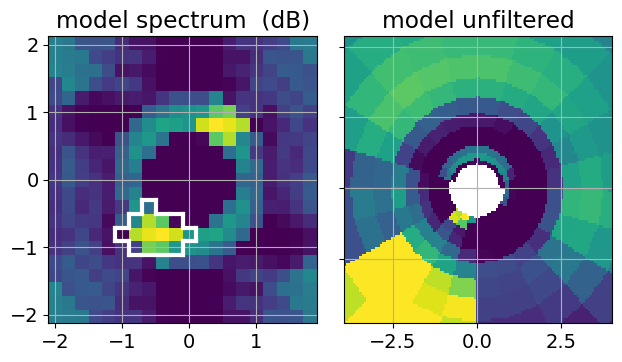

ind: 552167 1 552167 0.0030291835 test: 2023-06-09T17:00:00 114.0 -9.0
ind: 552163 1 552163 0.0032201146 test: 2023-06-09T17:00:00 114.0 -9.5
ind: 552163 1 552163 0.00075577816 test: 2023-06-09T17:00:00 114.0 -9.5
ind: 552163 1 552163 0.0039888173 test: 2023-06-09T17:00:00 114.0 -9.5
ind: 552159 1 552159 0.0029395032 test: 2023-06-09T17:00:00 114.0 -10.0
ind: 552159 1 552159 0.0017402683 test: 2023-06-09T17:00:00 114.0 -10.0
ind: 552159 1 552159 0.0049860496 test: 2023-06-09T17:00:00 114.0 -10.0
ind: 552156 1 552156 0.0025755302 test: 2023-06-09T17:00:00 114.5 -10.5
ind: 552156 1 552156 0.0024089767 test: 2023-06-09T17:00:00 114.5 -10.5
ind: 552152 1 552152 0.0048615905 test: 2023-06-09T17:00:00 114.5 -11.0
ind: 552152 1 552152 0.0016356291 test: 2023-06-09T17:00:00 114.5 -11.0
ind: 552152 1 552152 0.0027104607 test: 2023-06-09T17:00:00 114.5 -11.0
ind: 552148 1 552148 0.0038972357 test: 2023-06-09T17:00:00 114.5 -11.5
ind: 552148 1 552148 0.00065846153 test: 2023-06-09T17:00:00 114.5 

/tmp/ipykernel_1863652/115916119.py:60: RuntimeWarning: divide by zero encountered in log10
  im=ax[1].pcolormesh(-kxm[ix1:ix1+nkxr*6]*1000,-kym[iy1:iy1+nkxr*6]*1000,10*np.log10(Ekxky[ix1:ix1+nkxr*6,iy1:iy1+nkxr*6]).T,cmap='viridis',rasterized=True,vmin=-10+dBE2, vmax=30+dBE2)


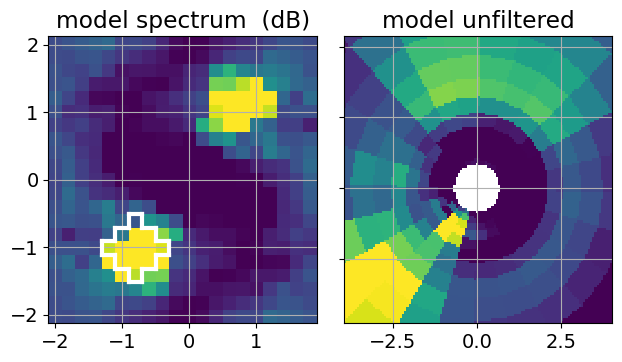

ind: 552097 1 552097 0.0015793781 test: 2023-06-09T17:00:00 115.5 -18.0
ind: 552093 1 552093 0.004350599 test: 2023-06-09T17:00:00 115.5 -18.5
ind: 552093 1 552093 0.0014643883 test: 2023-06-09T17:00:00 115.5 -18.5
ind: 552093 1 552093 0.0028816476 test: 2023-06-09T17:00:00 115.5 -18.5
ind: 552089 1 552089 0.00443319 test: 2023-06-09T17:00:00 115.5 -19.0
ind: 552089 1 552089 0.0015629227 test: 2023-06-09T17:00:00 115.5 -19.0
ind: 552089 1 552089 0.0042295405 test: 2023-06-09T17:00:00 115.5 -19.0
ind: 552084 1 552084 0.0045629675 test: 2023-06-09T17:00:00 115.5 -19.5


/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/wave_physics_functions.py:440: RuntimeWarning: overflow encountered in scalar power
  FD=-H-(X/(np.cosh(X)**2))
/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/wave_physics_functions.py:440: RuntimeWarning: overflow encountered in cosh
  FD=-H-(X/(np.cosh(X)**2))


ind: 552085 1 552085 0.0021869617 test: 2023-06-09T17:00:00 116.0 -19.5


/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/wave_physics_functions.py:440: RuntimeWarning: overflow encountered in scalar power
  FD=-H-(X/(np.cosh(X)**2))


ind: 552085 1 552085 0.0050735297 test: 2023-06-09T17:00:00 116.0 -19.5


/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/wave_physics_functions.py:440: RuntimeWarning: overflow encountered in scalar power
  FD=-H-(X/(np.cosh(X)**2))


ind: 552080 1 552080 0.0036787991 test: 2023-06-09T17:00:00 116.0 -20.0
ind: 552080 1 552080 0.002102529 test: 2023-06-09T17:00:00 116.0 -20.0
ind: 552080 1 552080 0.004972625 test: 2023-06-09T17:00:00 116.0 -20.0
ind: 552076 1 552076 0.0023256703 test: 2023-06-09T17:00:00 116.0 -20.5
ind: 552076 1 552076 0.0019679475 test: 2023-06-09T17:00:00 116.0 -20.5
ind: 552073 1 552073 0.004307315 test: 2023-06-09T17:00:00 116.0 -21.0
ind: 552073 1 552073 0.0010560856 test: 2023-06-09T17:00:00 116.0 -21.0
ind: 552073 1 552073 0.002439553 test: 2023-06-09T17:00:00 116.0 -21.0
ind: 552073 1 552073 0.005821654 test: 2023-06-09T17:00:00 116.0 -21.0
ind: 552073 1 552073 0.009250099 test: 2023-06-09T17:00:00 116.0 -21.0
ind: 552070 1 552070 0.012509644 test: 2023-06-09T17:00:00 115.0 -21.5
ind: 552070 1 552070 0.015965559 test: 2023-06-09T17:00:00 115.0 -21.5
ind: 552070 1 552070 0.01944144 test: 2023-06-09T17:00:00 115.0 -21.5
Did not find model spectrum for location (lon,lat): 116.23169 -22.19254  a

/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/wave_physics_functions.py:440: RuntimeWarning: overflow encountered in scalar power
  FD=-H-(X/(np.cosh(X)**2))


ind: 552069 1 552069 0.016050879 test: 2023-06-09T17:00:00 119.5 -34.5


/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/wave_physics_functions.py:440: RuntimeWarning: overflow encountered in scalar power
  FD=-H-(X/(np.cosh(X)**2))


ind: 552069 1 552069 0.012441095 test: 2023-06-09T17:00:00 119.5 -34.5


/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/wave_physics_functions.py:440: RuntimeWarning: overflow encountered in scalar power
  FD=-H-(X/(np.cosh(X)**2))


ind: 552069 1 552069 0.008786605 test: 2023-06-09T17:00:00 119.5 -34.5


/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/wave_physics_functions.py:440: RuntimeWarning: overflow encountered in scalar power
  FD=-H-(X/(np.cosh(X)**2))


ind: 552067 1 552067 0.0070552337 test: 2023-06-09T17:00:00 119.0 -35.0


/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/wave_physics_functions.py:440: RuntimeWarning: overflow encountered in scalar power
  FD=-H-(X/(np.cosh(X)**2))
/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/wave_physics_functions.py:440: RuntimeWarning: overflow encountered in cosh
  FD=-H-(X/(np.cosh(X)**2))


ind: 552067 1 552067 0.0033500523 test: 2023-06-09T17:00:00 119.0 -35.0


/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/wave_physics_functions.py:440: RuntimeWarning: overflow encountered in scalar power
  FD=-H-(X/(np.cosh(X)**2))
/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/wave_physics_functions.py:440: RuntimeWarning: overflow encountered in cosh
  FD=-H-(X/(np.cosh(X)**2))


ind: 552067 1 552067 0.00037228057 test: 2023-06-09T17:00:00 119.0 -35.0


/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/wave_physics_functions.py:440: RuntimeWarning: overflow encountered in scalar power
  FD=-H-(X/(np.cosh(X)**2))
/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/wave_physics_functions.py:440: RuntimeWarning: overflow encountered in cosh
  FD=-H-(X/(np.cosh(X)**2))


ind: 552067 1 552067 0.0041011767 test: 2023-06-09T17:00:00 119.0 -35.0


/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/wave_physics_functions.py:440: RuntimeWarning: overflow encountered in scalar power
  FD=-H-(X/(np.cosh(X)**2))
/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/wave_physics_functions.py:440: RuntimeWarning: overflow encountered in cosh
  FD=-H-(X/(np.cosh(X)**2))


ind: 552064 1 552064 0.0039958423 test: 2023-06-09T17:00:00 119.0 -35.5
ind: 552064 1 552064 0.002862156 test: 2023-06-09T17:00:00 119.0 -35.5
ind: 552064 1 552064 0.0066173896 test: 2023-06-09T17:00:00 119.0 -35.5


/tmp/ipykernel_1863652/115916119.py:60: RuntimeWarning: divide by zero encountered in log10
  im=ax[1].pcolormesh(-kxm[ix1:ix1+nkxr*6]*1000,-kym[iy1:iy1+nkxr*6]*1000,10*np.log10(Ekxky[ix1:ix1+nkxr*6,iy1:iy1+nkxr*6]).T,cmap='viridis',rasterized=True,vmin=-10+dBE2, vmax=30+dBE2)


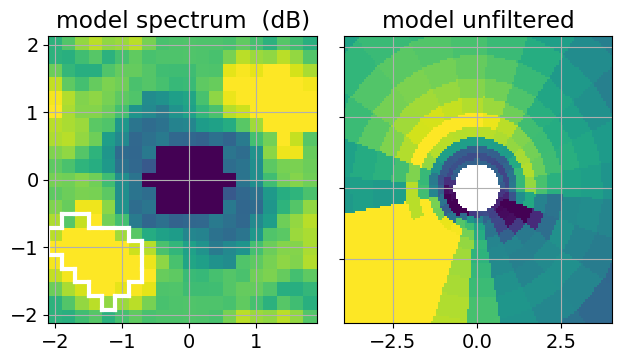

ind: 552060 1 552060 0.005306557 test: 2023-06-09T17:00:00 119.5 -36.0
ind: 552060 1 552060 0.0039865314 test: 2023-06-09T17:00:00 119.5 -36.0
ind: 552060 1 552060 0.0064209397 test: 2023-06-09T17:00:00 119.5 -36.0
ind: 552055 1 552055 0.0027685317 test: 2023-06-09T17:00:00 119.5 -36.5
ind: 552055 1 552055 0.0025302703 test: 2023-06-09T17:00:00 119.5 -36.5
ind: 552050 1 552050 0.00393669 test: 2023-06-09T17:00:00 119.5 -37.0
ind: 552050 1 552050 0.0013996612 test: 2023-06-09T17:00:00 119.5 -37.0
ind: 552050 1 552050 0.0036604886 test: 2023-06-09T17:00:00 119.5 -37.0
ind: 552046 1 552046 0.00537409 test: 2023-06-09T17:00:00 119.5 -37.5
ind: 552046 1 552046 0.00301243 test: 2023-06-09T17:00:00 119.5 -37.5
ind: 552046 1 552046 0.006403936 test: 2023-06-09T17:00:00 119.5 -37.5
ind: 552042 1 552042 0.0057825577 test: 2023-06-09T17:00:00 120.0 -38.0
ind: 552042 1 552042 0.002611855 test: 2023-06-09T17:00:00 120.0 -38.0
ind: 552042 1 552042 0.0049592475 test: 2023-06-09T17:00:00 120.0 -38.0
i

/tmp/ipykernel_1863652/115916119.py:60: RuntimeWarning: divide by zero encountered in log10
  im=ax[1].pcolormesh(-kxm[ix1:ix1+nkxr*6]*1000,-kym[iy1:iy1+nkxr*6]*1000,10*np.log10(Ekxky[ix1:ix1+nkxr*6,iy1:iy1+nkxr*6]).T,cmap='viridis',rasterized=True,vmin=-10+dBE2, vmax=30+dBE2)


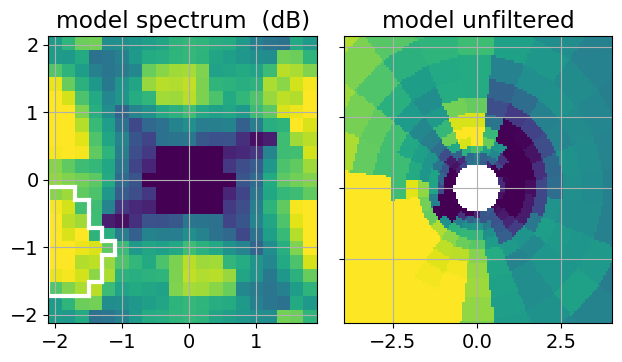

ind: 551981 1 551981 0.004619514 test: 2023-06-09T17:00:00 122.0 -44.5
ind: 551976 1 551976 0.0036675641 test: 2023-06-09T17:00:00 122.0 -45.0
ind: 551976 1 551976 0.004291713 test: 2023-06-09T17:00:00 122.0 -45.0
ind: 551976 1 551976 0.008513446 test: 2023-06-09T17:00:00 122.0 -45.0
ind: 551972 1 551972 0.004551801 test: 2023-06-09T17:00:00 122.5 -45.5
ind: 551972 1 551972 0.0037968643 test: 2023-06-09T17:00:00 122.5 -45.5
ind: 551967 1 551967 0.004815625 test: 2023-06-09T17:00:00 122.5 -46.0
ind: 551967 1 551967 0.0011840358 test: 2023-06-09T17:00:00 122.5 -46.0
ind: 551967 1 551967 0.0037118508 test: 2023-06-09T17:00:00 122.5 -46.0
ind: 551961 1 551961 0.0062388154 test: 2023-06-09T17:00:00 122.5 -46.5
ind: 551961 1 551961 0.0044272817 test: 2023-06-09T17:00:00 122.5 -46.5
ind: 551962 1 551962 0.0061359946 test: 2023-06-09T17:00:00 123.0 -46.5
ind: 553662 1 553662 0.0052933972 test: 2023-06-09T17:30:00 123.0 -47.0
ind: 553662 1 553662 0.0009927192 test: 2023-06-09T17:30:00 123.0 -47

/tmp/ipykernel_1863652/115916119.py:60: RuntimeWarning: divide by zero encountered in log10
  im=ax[1].pcolormesh(-kxm[ix1:ix1+nkxr*6]*1000,-kym[iy1:iy1+nkxr*6]*1000,10*np.log10(Ekxky[ix1:ix1+nkxr*6,iy1:iy1+nkxr*6]).T,cmap='viridis',rasterized=True,vmin=-10+dBE2, vmax=30+dBE2)


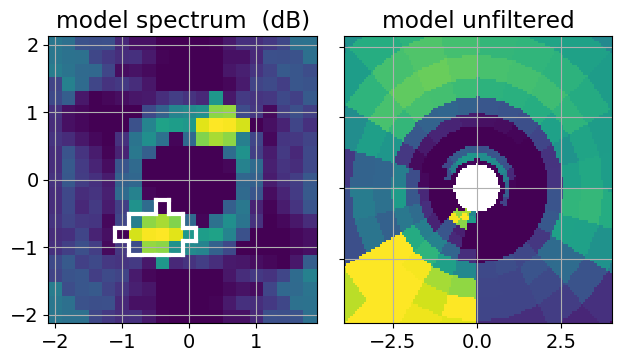

ind: 552166 1 552166 0.004344581 test: 2023-06-09T17:00:00 113.5 -9.0
ind: 552162 1 552162 0.0019442565 test: 2023-06-09T17:00:00 113.5 -9.5
ind: 552162 1 552162 0.0020737946 test: 2023-06-09T17:00:00 113.5 -9.5
ind: 552158 1 552158 0.004657597 test: 2023-06-09T17:00:00 113.5 -10.0
ind: 552158 1 552158 0.0016568128 test: 2023-06-09T17:00:00 113.5 -10.0
ind: 552158 1 552158 0.00306084 test: 2023-06-09T17:00:00 113.5 -10.0
ind: 552154 1 552154 0.0043944083 test: 2023-06-09T17:00:00 113.5 -10.5
ind: 552155 1 552155 0.0012611917 test: 2023-06-09T17:00:00 114.0 -10.5
ind: 552155 1 552155 0.0037055893 test: 2023-06-09T17:00:00 114.0 -10.5
ind: 552151 1 552151 0.0035447448 test: 2023-06-09T17:00:00 114.0 -11.0
ind: 552151 1 552151 0.0010060616 test: 2023-06-09T17:00:00 114.0 -11.0
ind: 552151 1 552151 0.0040140143 test: 2023-06-09T17:00:00 114.0 -11.0
ind: 552147 1 552147 0.0025781372 test: 2023-06-09T17:00:00 114.0 -11.5
ind: 552147 1 552147 0.0012892014 test: 2023-06-09T17:00:00 114.0 -11.5

/tmp/ipykernel_1863652/115916119.py:60: RuntimeWarning: divide by zero encountered in log10
  im=ax[1].pcolormesh(-kxm[ix1:ix1+nkxr*6]*1000,-kym[iy1:iy1+nkxr*6]*1000,10*np.log10(Ekxky[ix1:ix1+nkxr*6,iy1:iy1+nkxr*6]).T,cmap='viridis',rasterized=True,vmin=-10+dBE2, vmax=30+dBE2)


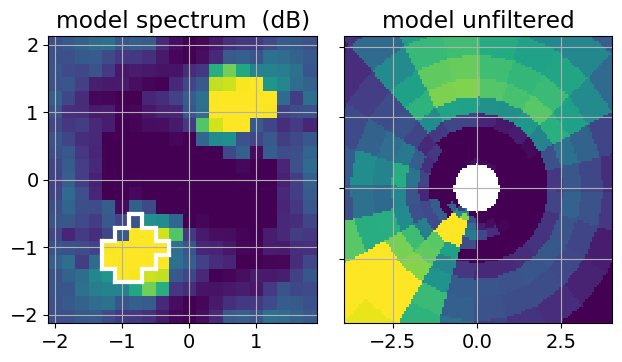

ind: 552096 1 552096 0.0029711723 test: 2023-06-09T17:00:00 115.0 -18.0
ind: 552092 1 552092 0.002856613 test: 2023-06-09T17:00:00 115.0 -18.5
ind: 552092 1 552092 0.00082649465 test: 2023-06-09T17:00:00 115.0 -18.5
ind: 552092 1 552092 0.004173027 test: 2023-06-09T17:00:00 115.0 -18.5
ind: 552088 1 552088 0.0029177458 test: 2023-06-09T17:00:00 115.0 -19.0
ind: 552088 1 552088 0.0021538462 test: 2023-06-09T17:00:00 115.0 -19.0
ind: 552088 1 552088 0.0055144383 test: 2023-06-09T17:00:00 115.0 -19.0
ind: 552083 1 552083 0.003026258 test: 2023-06-09T17:00:00 115.0 -19.5
ind: 552083 1 552083 0.0035247328 test: 2023-06-09T17:00:00 115.0 -19.5
ind: 552079 1 552079 0.005754489 test: 2023-06-09T17:00:00 115.5 -20.0
ind: 552079 1 552079 0.0024078484 test: 2023-06-09T17:00:00 115.5 -20.0
ind: 552079 1 552079 0.0036764524 test: 2023-06-09T17:00:00 115.5 -20.0
ind: 552075 1 552075 0.004426509 test: 2023-06-09T17:00:00 115.5 -20.5
ind: 552075 1 552075 0.0010617058 test: 2023-06-09T17:00:00 115.5 -2

/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/wave_physics_functions.py:440: RuntimeWarning: overflow encountered in scalar power
  FD=-H-(X/(np.cosh(X)**2))


ind: 552066 1 552066 0.01383437 test: 2023-06-09T17:00:00 118.5 -35.0


/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/wave_physics_functions.py:440: RuntimeWarning: overflow encountered in scalar power
  FD=-H-(X/(np.cosh(X)**2))


ind: 552066 1 552066 0.01012092 test: 2023-06-09T17:00:00 118.5 -35.0


/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/wave_physics_functions.py:440: RuntimeWarning: overflow encountered in scalar power
  FD=-H-(X/(np.cosh(X)**2))


ind: 552066 1 552066 0.006503463 test: 2023-06-09T17:00:00 118.5 -35.0


/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/wave_physics_functions.py:440: RuntimeWarning: overflow encountered in scalar power
  FD=-H-(X/(np.cosh(X)**2))


ind: 552066 1 552066 0.0027646993 test: 2023-06-09T17:00:00 118.5 -35.0


/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/wave_physics_functions.py:440: RuntimeWarning: overflow encountered in scalar power
  FD=-H-(X/(np.cosh(X)**2))


ind: 552066 1 552066 0.0028240937 test: 2023-06-09T17:00:00 118.5 -35.0


/home/ardhuin/PUBLI/2024_SWELLSWOT/CLEAN/wave_physics_functions.py:440: RuntimeWarning: overflow encountered in scalar power
  FD=-H-(X/(np.cosh(X)**2))


ind: 552063 1 552063 0.0040719905 test: 2023-06-09T17:00:00 118.5 -35.5
ind: 552063 1 552063 0.0009284329 test: 2023-06-09T17:00:00 118.5 -35.5
ind: 552063 1 552063 0.0033833515 test: 2023-06-09T17:00:00 118.5 -35.5
ind: 552058 1 552058 0.004720292 test: 2023-06-09T17:00:00 118.5 -36.0


/tmp/ipykernel_1863652/115916119.py:60: RuntimeWarning: divide by zero encountered in log10
  im=ax[1].pcolormesh(-kxm[ix1:ix1+nkxr*6]*1000,-kym[iy1:iy1+nkxr*6]*1000,10*np.log10(Ekxky[ix1:ix1+nkxr*6,iy1:iy1+nkxr*6]).T,cmap='viridis',rasterized=True,vmin=-10+dBE2, vmax=30+dBE2)


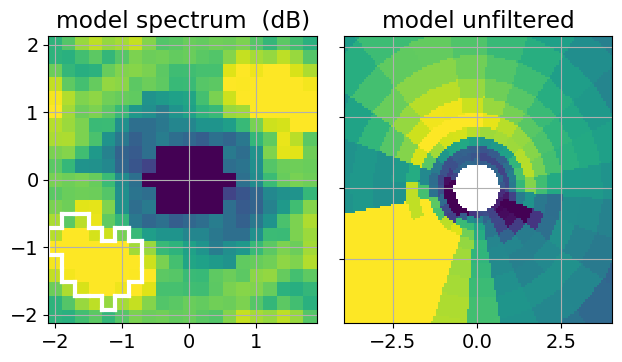

ind: 552058 1 552058 0.0022661851 test: 2023-06-09T17:00:00 118.5 -36.0
ind: 552058 1 552058 0.005904681 test: 2023-06-09T17:00:00 118.5 -36.0
ind: 552054 1 552054 0.006076882 test: 2023-06-09T17:00:00 119.0 -36.5
ind: 552054 1 552054 0.003362678 test: 2023-06-09T17:00:00 119.0 -36.5
ind: 552054 1 552054 0.0058079567 test: 2023-06-09T17:00:00 119.0 -36.5
ind: 552049 1 552049 0.0035351233 test: 2023-06-09T17:00:00 119.0 -37.0
ind: 552049 1 552049 0.0019382056 test: 2023-06-09T17:00:00 119.0 -37.0
ind: 552049 1 552049 0.004353596 test: 2023-06-09T17:00:00 119.0 -37.0
ind: 552045 1 552045 0.0019697836 test: 2023-06-09T17:00:00 119.0 -37.5
ind: 552045 1 552045 0.0028989848 test: 2023-06-09T17:00:00 119.0 -37.5
ind: 552040 1 552040 0.005921255 test: 2023-06-09T17:00:00 119.0 -38.0
ind: 552040 1 552040 0.0035478957 test: 2023-06-09T17:00:00 119.0 -38.0
ind: 552040 1 552040 0.005643311 test: 2023-06-09T17:00:00 119.0 -38.0
ind: 552036 1 552036 0.006601492 test: 2023-06-09T17:00:00 119.5 -38.5

/tmp/ipykernel_1863652/115916119.py:60: RuntimeWarning: divide by zero encountered in log10
  im=ax[1].pcolormesh(-kxm[ix1:ix1+nkxr*6]*1000,-kym[iy1:iy1+nkxr*6]*1000,10*np.log10(Ekxky[ix1:ix1+nkxr*6,iy1:iy1+nkxr*6]).T,cmap='viridis',rasterized=True,vmin=-10+dBE2, vmax=30+dBE2)


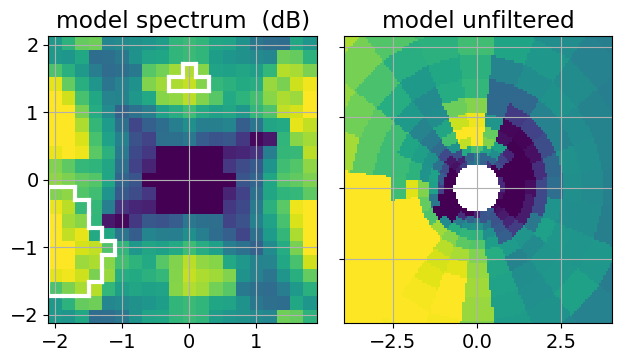

ind: 551975 1 551975 0.0048082704 test: 2023-06-09T17:00:00 121.5 -45.0
ind: 551975 1 551975 0.0014952881 test: 2023-06-09T17:00:00 121.5 -45.0
ind: 551975 1 551975 0.003520816 test: 2023-06-09T17:00:00 121.5 -45.0
ind: 551970 1 551970 0.0033001462 test: 2023-06-09T17:00:00 121.5 -45.5
ind: 551970 1 551970 0.0031819502 test: 2023-06-09T17:00:00 121.5 -45.5
ind: 551970 1 551970 0.007398888 test: 2023-06-09T17:00:00 121.5 -45.5
ind: 551966 1 551966 0.005721158 test: 2023-06-09T17:00:00 122.0 -46.0
ind: 551966 1 551966 0.004290923 test: 2023-06-09T17:00:00 122.0 -46.0
ind: 551960 1 551960 0.005987035 test: 2023-06-09T17:00:00 122.0 -46.5
ind: 551960 1 551960 0.0017358956 test: 2023-06-09T17:00:00 122.0 -46.5
ind: 551960 1 551960 0.0025306772 test: 2023-06-09T17:00:00 122.0 -46.5
ind: 551955 1 551955 0.0056602834 test: 2023-06-09T17:00:00 122.0 -47.0
ind: 553660 1 553660 0.0038315558 test: 2023-06-09T17:30:00 122.0 -47.0
ind: 553660 1 553660 0.006710378 test: 2023-06-09T17:30:00 122.0 -47.

In [9]:
modeltag2='PR1v1' 
modeltag2='GLOBAL_REF102040' 
file_swot=file_listnc[0]
tags=file_swot.split(sep='/')
filenopath=tags[-1]
days=filenopath[27:len(filenopath)]



# This opens the WAVEWATCH III spectra file (computed for B. Molero).
filetr='/media/ardhuin/FabLinux/WW3-SWOT/'+modeltag2+'/SWOT_WW3-GLOB-30M_202306_trck.nc'

print('file:',filetr)


ds_ww3t = xr.open_dataset(filetr)

bigarray_L3Sb=np.zeros((L3Snt*2,50))

indf=0
for indside in range(2): 
  for indt in range(L3Snt): 
    L3S_ind =L3Snc.index_model[indt,0,indside].values
    time=L3Snc.time[indt].values
    lon=L3Snc.longitude_40[indt,0,indside].values
    lat=L3Snc.latitude_40[indt,0,indside].values
    L3S_amask =L3Snc.mask_40[indt,0,indside,:,:].values

    #efth=ds_ww3t.efth[L3S_ind].squeeze().values  
    modspec,indww3,modelfound,timeww3,lonww3,latww3,distww3,U10,Udir,dpt=swell.SWOTfind_model_spectrum(ds_ww3t,lon,lat,time) 
    if (modelfound==1):
       efth=modspec.values  
       [Ef,th1m,sth1m,Hs,Tm0m1,Tm02,Qf,Qkk] = wavespec_Efth_to_first3(efth,modf,moddf,modang,moddth,cut=100.) 
       print('ind:',indww3,modelfound,L3S_ind,distww3,'test:',timeww3,lonww3,latww3)
       sigu=(Hs/4)*(2*np.pi/Tm02)
       lambdac=1/((7310/875.0e3)/sigu/(2*np.pi))

      
       Hazc = np.exp(-(kyr2*lambdac)**2)        # this is the effect of velocity bunching for sigma0 ... what about the phase? 
       H3=H*Hptr*Hazc
               
       Eta_WW3_obp_H2,Eta_WW3_obp_H,Eta_WW3_noa_H2,Eta_WW3_res,Eta_WW3_c,Ekxky,kxm,kym,ix1,iy1= \
                              swell.wavespec_Efth_to_kxky_SWOT(efth,modf,moddf, modang,moddth,f_xt,f_at,H,Hazc,H3, \
                                            kxmax,kymax,dkx,dky,dkxr,dkyr,nkxr,nkyr,depth=dpt,doublesided=0,verbose=0,trackangle=(L3S_trackangle[indt]+sflip*180)*np.pi/180)
        

       if (np.mod(indt,50)==0):
               dBE=0;dBE2=10;
               vertices=swell.SWOTspec_mask_polygon(L3S_amask) 
               fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(6,3.5))
               spec = mpl.gridspec.GridSpec(ncols=2, nrows=1,width_ratios=[6, 5])
               plt.subplots_adjust(left=0.05,bottom=0.1, top=0.92,wspace=0.1,right=0.99)
    
# Plotting WW3 spectrum, same resolution as SWOT spectrum 
               im=ax[0].pcolormesh(L3S_kx2*1000,L3S_ky2*1000,10*np.log10(Eta_WW3_obp_H2),cmap='viridis',rasterized=True,vmin = -10+dBE, vmax=30+dBE)
               _=ax[0].set_title('model spectrum  (dB)')
               swell.draw_mask(ax[0],L3S_kx2,dkx,L3S_ky2,dky,vertices,color='w',lw=3) 
                
# Plotting WW3 spectrum, same resolution as SWOT spectrum but 2 x spectral range and no ambiguity in direction 
               im=ax[1].pcolormesh(-kxm[ix1:ix1+nkxr*6]*1000,-kym[iy1:iy1+nkxr*6]*1000,10*np.log10(Ekxky[ix1:ix1+nkxr*6,iy1:iy1+nkxr*6]).T,cmap='viridis',rasterized=True,vmin=-10+dBE2, vmax=30+dBE2)
               _=ax[1].set_title('model unfiltered')
               plt.setp(ax[1].get_yticklabels(), visible=False)
               plt.show()

      
       Hazc_new =np.exp(-(L3S_ky2*lambdac)**2)

       HHC=(HH1)**calibration  # calibration of the PTR
       HH3=HHC*Hazc_new  # filter corrected with calibration for Hptr and new cut-off for Hazc. 
       Hsnew,Lmm1new,Lmnew,dmnew,Q18=swell.SWOTspec_to_HsLm(Eta_WW3_obp_H2,L3S_kx2,L3S_ky2,L3S_amask,HH3,L3S_trackangle[indt])
       bigarray_L3Sb[indf,11]=Hsnew 
       bigarray_L3Sb[indf,21]=Lmnew 
       bigarray_L3Sb[indf,31]=dmnew 
       bigarray_L3Sb[indf,4]=lambdac
       bigarray_L3Sb[indf,41]=Q18
    
      
    indf=indf+1
#L3Snc.close()  # close the L3 spectra file

size of arrays: 236


/tmp/ipykernel_1863652/1719619490.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0].scatter(bigarray_L3S[s1:-1,10],bigarray_L3S[s1:-1,2],c=gr,alpha=0.5,linewidth=1,label='SWOT');
/tmp/ipykernel_1863652/1719619490.py:38: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[1].scatter(bigarray_L3S[s1:-1,20],bigarray_L3S[s1:-1,2],c=gr,alpha=0.5,linewidth=1,label='SWOT');
/tmp/ipykernel_1863652/1719619490.py:62: UserWarni

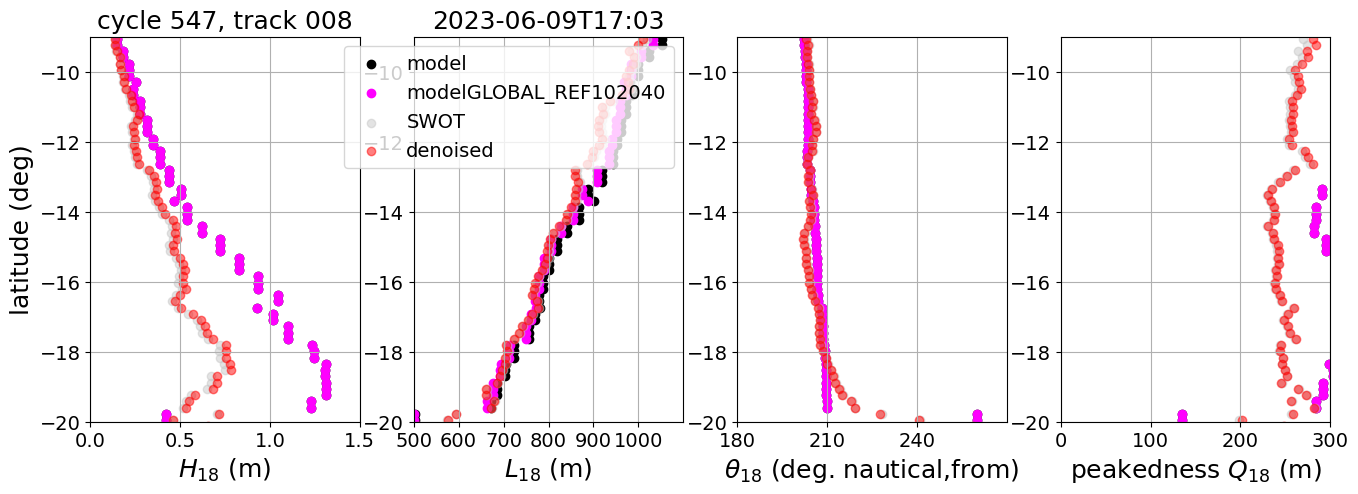

In [10]:
gr=[0.,205./255.,0.]
fig,axs=plt.subplots(1,4,figsize=(16,figh))
vecHs=np.linspace(1,12,23)
s1=indt;s2=-1 # for right swath only 
#s1=0;s2=indt # for right swath only 
print('size of arrays:',indt) 

if s1 < indt  :
   axs[0].scatter(bigarray_L3S[s1:s2,11],bigarray_L3S[s1:s2,2],c='black',linewidth=1,label='model left');
   axs[0].scatter(bigarray_L3S[s2:-1,11],bigarray_L3S[s2:-1,2],c='blue',linewidth=1,label='model  right');
   axs[0].scatter(bigarray_L3S[s2:-1,10],bigarray_L3S[s2:-1,2],c=gr,linewidth=1,label='SWOT  right');
   axs[0].scatter(bigarray_L3S[s1:s2,10],bigarray_L3S[s1:s2,2],c='red',linewidth=1,label='SWOT left');
else: 
   gr=[200./255.,200./255.,200./255.]
   gS=[80./255.,255./255.,80./255.]
   axs[0].scatter(bigarray_L3S[s1:-1,11],bigarray_L3S[s1:-1,2],c='black',linewidth=1,label='model');
   axs[0].scatter(bigarray_L3Sb[s1:-1,11],bigarray_L3S[s1:-1,2],c='magenta',linewidth=1,label='model'+modeltag2); 
   axs[0].scatter(bigarray_L3S[s1:-1,10],bigarray_L3S[s1:-1,2],c=gr,alpha=0.5,linewidth=1,label='SWOT');
   if (denoise==1):
      axs[0].scatter(bigarray_L3S[s1:-1,12],bigarray_L3S[s1:-1,2],c='red',alpha=0.5,linewidth=1,label='denoised');
   
    
axs[0].set_xlabel(r'$H_{18}$ (m)', fontsize=18)
axs[0].set_ylabel('latitude (deg)', fontsize=18)
axs[0].set_title(tracktag, fontsize=18)
axs[0].set_xlim(Hrange);
#axs[0].set_xlim([0,5]);
axs[0].set_ylim(latrange)

if s1 < indt  :
   axs[1].scatter(bigarray[0:nfiles,21],bigarray[0:nfiles,2],c='black',linewidth=1,label='model left');
   axs[1].scatter(bigarray[nfiles+1:-1,21],bigarray[nfiles+1:-1,2],c='blue',linewidth=1,label='model  right');
   axs[1].scatter(bigarray[nfiles+1:-1,20],bigarray[nfiles+1:-1,2],c=gr,linewidth=1,label='SWOT  right');
   axs[1].scatter(bigarray[0:nfiles,20],bigarray[0:nfiles,2],c='red',linewidth=1,label='SWOT left');
else: 
   axs[1].scatter(bigarray_L3S[s1:-1,21],bigarray_L3S[s1:-1,2],c='black',linewidth=1,label='model'); 
   axs[1].scatter(bigarray_L3Sb[s1:-1,21],bigarray_L3S[s1:-1,2],c='magenta',linewidth=1,label='model'+modeltag2); 
   axs[1].scatter(bigarray_L3S[s1:-1,20],bigarray_L3S[s1:-1,2],c=gr,alpha=0.5,linewidth=1,label='SWOT'); 
   if (denoise==1):
      axs[1].scatter(bigarray_L3S[s1:-1,22],bigarray_L3S[s1:-1,2],c='red',alpha=0.5,linewidth=1,label='denoised');

axs[1].set_xlabel(r'$L_{18}$ (m)', fontsize=18)
format = '%Y-%m-%dT%H:%M:%S'
axs[1].set_title(str(timec)[0:16], fontsize=18)
axs[1].set_xlim(Lrange)
axs[1].set_xticks(np.arange(Lrange[0],Lrange[1],Lstep))
#axs[1].set_xlim([450,650])
#axs[1].set_xticks(np.arange(450,650,50))
axs[1].set_ylim(latrange)
leg = axs[ileg].legend(loc=locleg, fontsize=14)

lightcmap = cmocean.tools.lighten(cmo.ice_r, 0.5)

if s1 < indt  :
   axs[2].scatter(bigarray_L3S[s1:s2,31],bigarray_L3S[s1:s2,2],c='black',linewidth=1,label='model left');
   axs[2].scatter(bigarray_L3S[s2:-1,31],bigarray_L3S[s2:-1,2],c='blue',linewidth=1,label='model right');
   axs[2].scatter(bigarray_L3S[s2:-1,30],bigarray_L3S[s2:-1,2],c=gr,linewidth=1,label='SWOT right');
   axs[2].scatter(bigarray_L3S[s1:s2,30],bigarray_L3S[s1:s2,2],c='red',linewidth=1,label='SWOT left');
else: 
   axs[2].scatter(bigarray_L3S[s1:-1,31],bigarray_L3S[s1:-1,2],c='black',linewidth=1,label='model'); 
   axs[2].scatter(bigarray_L3Sb[s1:-1,31],bigarray_L3S[s1:-1,2],c='magenta',linewidth=1,label='model'+modeltag2); 
   axs[2].scatter(bigarray_L3S[s1:-1,30],bigarray_L3S[s1:-1,2],c=gr,alpha=0.5,linewidth=1,label='SWOT');
   if (denoise==1):
     axs[2].scatter(bigarray_L3S[s1:-1,32],bigarray_L3S[s1:-1,2],c='red',alpha=0.5,linewidth=1,label='denoised');

axs[2].set_xlabel(r'$\theta_{18}$ (deg. nautical,from)', fontsize=18)
axs[2].set_xlim(thrange)
axs[2].set_xticks(np.arange(thrange[0],thrange[1],thstep))
axs[2].set_ylim(latrange)
#axs[2].set_title(tracktag)

if s1 < indt  :
   axs[3].scatter(bigarray_L3S[s1:s2,40],bigarray[s2:-1,2],c='black',linewidth=1,label='model left');
   axs[3].scatter(bigarray_L3S[s2:-1,40],bigarray[s2:-1,2],c='blue',linewidth=1,label='model right');
else: 
   axs[3].scatter(bigarray_L3S[s1:s2,41],bigarray_L3S[s1:-1,2],c='black',linewidth=1,label='model PR3-UQ'); 
   axs[3].scatter(bigarray_L3Sb[s1:s2,41],bigarray_L3S[s1:-1,2],c='magenta',linewidth=1,label='model '+modeltag2); 
   axs[3].scatter(bigarray_L3S[s1:s2,40],bigarray_L3S[s1:s2,2],c=gr,alpha=0.5,linewidth=1,label='SWOT');
   if (denoise==1):
     axs[3].scatter(bigarray_L3S[s1:s2,42],bigarray_L3S[s1:s2,2],c='red',alpha=0.5,linewidth=1,label='denoised');

axs[3].set_xlabel(r'peakedness $Q_{18}$ (m)', fontsize=18)    
axs[3].set_xlim([0,300])
axs[3].set_ylim(latrange)
fig.savefig('fulltrack_'+str(cycle)+'_'+str(tracks)+'_'+modeltag2+'_H2azc_cal_'+f'{abs(calibration):03.1f}'+'L3.pdf')
       